# Plug flow reactor simulation of Thruster

![caption](Graphics/thruster-details.png)


In [1]:
import cantera as ct
import numpy as np

from matplotlib import pyplot as plt
import csv
import pandas as pd

In [2]:
# input file containing the surface reaction mechanism
cti_file = '../RMG-model/cantera/chem_annotated.cti'

cti_file = '../RMG-model/cantera/chem0050.cti'

gas=ct.Solution(cti_file)
surf = ct.Interface(cti_file,'surface1', [gas])

In [3]:
gas()


  gas:

       temperature             300  K
          pressure          101325  Pa
           density         0.81974  kg/m^3
  mean mol. weight         20.1797  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          1905.6        3.845e+04     J
   internal energy      -1.217e+05       -2.456e+06     J
           entropy          7257.7        1.465e+05     J/K
    Gibbs function     -2.1754e+06        -4.39e+07     J
 heat capacity c_p          1030.1        2.079e+04     J/K
 heat capacity c_v          618.03        1.247e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                Ne              1                1         -17.5994
     [  +37 minor]              0                0



In [4]:
print(", ".join(gas.species_names))

Ne, H4N2O2(2), NH2OH(3), HNO3(4), CH3OH(5), H2O(6), N2(7), O2(8), NO2(9), NO(10), N2O(11), CO2(12), H2(13), CO(14), CH4(15), C2H6(16), CH2O(17), CH3(18), C3H8(19), H(20), C2H5(21), HCO(22), CH3CHO(23), OH(24), C2H4(25), HO2(39), NH2(85), H2NO(89), HNOH(94), N2H3(99), H3N2O(193), H2NO2(195), S(196), H2NO3(252), H2N2O(502), NNDO(506), NNO(515), S(566)


In [5]:
print(", ".join(surf.species_names))

X(1), HX(26), OX(27), CH3X(28), HOX(29), H2OX(30), CO2X(31), OCX(32), CX(33), CH2X(34), CHX(35), H2NX(212), SX(215), H2NOX(217), H3NOX(218), HNO3X(221), CH3OX(223), CH4OX(224)




This example solves a plug flow reactor problem, with coupled surface and gas chemistry.





In [6]:
# unit conversion factors to SI
cm = 0.01 # m
minute = 60.0  # s

In [7]:
#######################################################################
# Input Parameters for combustor
#######################################################################
mass_flow_rate =  0.5e-3 # kg/s
temperature_c = 400.0  # Initial Temperature in Celsius
pressure = ct.one_atm # constant

length = 1.1 * cm  # Catalyst bed length. 11mm
cross_section_area = np.pi * (0.9*cm)**2  # Catalyst bed area.  18mm diameter circle.

### Catalyst properties. Some are hard to estimate
# if we can, update this lit value or verify the value richard calculated
cat_specific_area = 140 # m2/g
cat_density = 2 / cm**3 # 2 g/m3
print(f"Catalyst density {cat_density :.2e} g/m3")
cat_area_per_vol = cat_specific_area * cat_density # m2/m3
cat_area_per_vol *= 1e-2 # REDUCE BY 100x
print(f"Catalyst area per volume {cat_area_per_vol :.2e} m2/m3")
print()

porosity = 0.38  # Catalyst bed porosity (0.38)
# Al2O3 particles are about 0.7mm diameter

Catalyst density 2.00e+06 g/m3
Catalyst area per volume 2.80e+06 m2/m3



In [8]:
output_filename = 'surf_pfr_output.csv'

# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 2001
# dt = 1.0

#####################################################################

temperature_kelvin = temperature_c + 273.15  # convert to Kelvin

# import the gas model and set the initial conditions
gas = ct.Solution(cti_file, 'gas')

# should this be mole fractions or mole fractions?
gas.TPY = temperature_kelvin, pressure, 'H4N2O2(2):0.14, NH2OH(3):0.3, HNO3(4):0.3, CH3OH(5):0.16, H2O(6):0.04'

# import the surface model
surf = ct.Interface(cti_file,'surface1', [gas])
surf.TP = temperature_kelvin, pressure
surf.coverages = 'X(1):1.0'

r_len = length/(NReactors-1) 
r_vol = cross_section_area * r_len * porosity # gas volume

outfile = open(output_filename,'w')
writer = csv.writer(outfile)
writer.writerow(['Distance (mm)', 'T (C)', 'P (atm)'] +
                gas.species_names + surf.species_names + ['alpha'])

# catalyst area in one reactor
cat_area = cat_area_per_vol * r_vol

# Not sure we need the velocity
velocity = mass_flow_rate / (gas.density * cross_section_area)


  surface1:

       temperature          673.15  K
          pressure          101325  Pa
           density     5.67815e-06  kg/m^3
  mean mol. weight         195.798  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy          -35624       -6.975e+06     J
   internal energy          -35624       -6.975e+06     J
           entropy          18.503             3623     J/K
    Gibbs function          -48080       -9.414e+06     J
 heat capacity c_p          6.8717             1345     J/K
 heat capacity c_v          6.8717             1345     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
              X(1)        0.96173         0.958217       -0.0390607
            HX(26)      0.0130517        0.0130712         -10.1136
            OX(27)    2.48773e-09      2.68193e-09          -47.256
          CH3X(28)    3

array([9.61729961e-01, 1.30516842e-02, 2.48773422e-09, 3.69434260e-12,
       4.03309139e-11, 4.37805162e-04, 6.68357035e-12, 2.47804464e-02,
       8.67930066e-10, 1.71500968e-13, 9.96203109e-08, 5.19264902e-19,
       2.26120978e-62, 5.97606004e-34, 4.77788156e-33, 6.54390424e-24,
       2.27947873e-11, 3.71556620e-16])

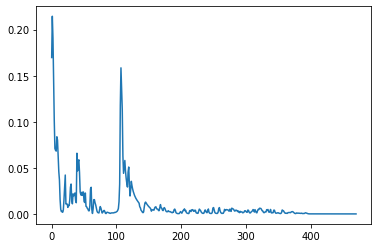

In [9]:
# To find the starting coverages, we run the gas to equilibrium,
# (i.e mostly burned products)  then put that in steady state
# with the surface.
TPY = gas.TPY # store to restore
gas.equilibrate('TP')
r = ct.IdealGasReactor(gas, energy='off')
r.volume = r_vol
rsurf = ct.ReactorSurface(surf, r, A=cat_area)
sim = ct.ReactorNet([r])
plt.plot(sim.advance_to_steady_state(return_residuals=True))
surf()
starting_coverages = surf.coverages
gas.TPY = TPY # restore
del(r, rsurf)
starting_coverages

<BarContainer object of 38 artists>

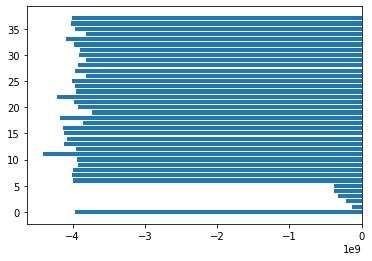

In [10]:
plt.barh(np.arange(len(gas.chemical_potentials)),gas.chemical_potentials)

In [11]:
# gas.equilibrate('TP')

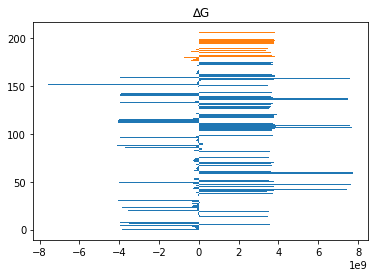

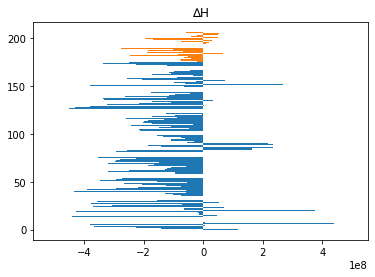

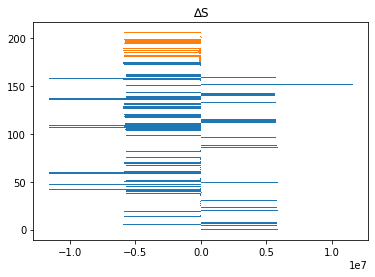

In [12]:
plt.barh(np.arange(len(gas.delta_gibbs)),gas.delta_gibbs)
plt.barh(len(gas.delta_gibbs)+np.arange(len(surf.delta_gibbs)),surf.delta_gibbs)
plt.title("∆G")
plt.show()
plt.barh(np.arange(len(gas.delta_enthalpy)),gas.delta_enthalpy)
plt.barh(len(gas.delta_enthalpy)+np.arange(len(surf.delta_enthalpy)),surf.delta_enthalpy)
plt.title('∆H')
plt.show()
plt.barh(np.arange(len(gas.delta_entropy)),gas.delta_entropy)
plt.barh(len(gas.delta_entropy)+np.arange(len(surf.delta_entropy)),surf.delta_entropy)
plt.title('∆S')
plt.show()

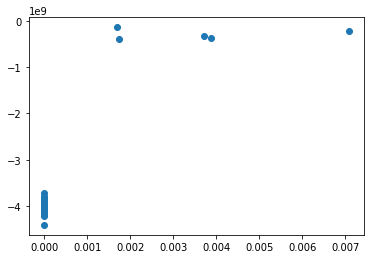

In [13]:
plt.plot(gas.concentrations, gas.chemical_potentials, 'o')

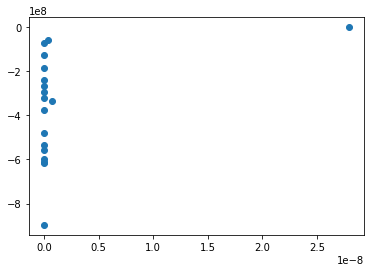

In [14]:
plt.plot(surf.concentrations, surf.chemical_potentials, 'o')

In [15]:
def report_rates(n=8):
    print("\nHighest net rates of progress, gas")
    for i in np.argsort(abs(gas.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.net_rates_of_progress[i]:8.1g}")
    print("\nHighest net rates of progress, surface")
    for i in np.argsort(abs(surf.net_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.net_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, gas")
    for i in np.argsort(abs(gas.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest forward rates of progress, surface")
    for i in np.argsort(abs(surf.forward_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.forward_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, gas")
    for i in np.argsort(abs(gas.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rates_of_progress[i]:8.1g}")
    print("\nHighest reverse rates of progress, surface")
    for i in np.argsort(abs(surf.reverse_rates_of_progress))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {cat_area_per_vol*surf.reverse_rates_of_progress[i]:8.1g}")

    print(f"\nSurface rates have been scaled by surface/volume ratio {cat_area_per_vol:.1e} m2/m3")
    print("So are on a similar basis of volume of reactor (though porosity not yet accounted for)")
    print(" kmol / m3 / s")
report_rates()


Highest net rates of progress, gas
 60 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -7e+06
 59 : H3N2O(193) + OH(24) <=> H4N2O2(2)                   -7e+06
107 : HO2(39) + N2H3(99) <=> H4N2O2(2)                    -1e+02
 47 : NO2(9) + OH(24) (+M) <=> HNO3(4) (+M)               -0.002
109 : H(20) + S(196) <=> H4N2O2(2)                        -1e-05
123 : H2NO3(252) + S(196) <=> H4N2O2(2) + HNO3(4)         -6e-06
158 : H2NO2(195) + NH2(85) <=> H4N2O2(2)                  -7e-07

Highest net rates of progress, surface
  0 : H2O(6) + X(1) <=> H2OX(30)                          -5e+06
  1 : NH2OH(3) + X(1) <=> H3NOX(218)                       3e+05
  3 : CH3OH(5) + X(1) <=> CH4OX(224)                       2e+05
  2 : HNO3(4) + X(1) <=> HNO3X(221)                        1e+05
  4 : H4N2O2(2) + X(1) <=> SX(215)                         5e+04
  5 : H2(13) + 2 X(1) <=> 2 HX(26)                        -4e+04
 10 : NH2OH(3) + 2 X(1) <=> H2NOX(217) + HX(26)            3e+01

Highest forwa

In [16]:
def report_rate_constants(n=8):
    print("\nHighest forward rate constants, gas")
    for i in np.argsort(abs(gas.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.forward_rate_constants[i]:8.1e}")
    print("\nHighest forward rate constants, surface")
    for i in np.argsort(abs(surf.forward_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.forward_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, gas")
    for i in np.argsort(abs(gas.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {gas.reaction_equation(i):48s}  {gas.reverse_rate_constants[i]:8.1e}")
    print("\nHighest reverse rate constants, surface")
    for i in np.argsort(abs(surf.reverse_rate_constants))[-1:-n:-1]: # top n in descending order
        print(f"{i:3d} : {surf.reaction_equation(i):48s}  {surf.reverse_rate_constants[i]:8.1e}")

    print("Units are a combination of kmol, m^3 and s, that depend on the rate expression for the reaction.")
report_rate_constants()


Highest forward rate constants, gas
157 : NH2(85) + NO(10) <=> NNDO(506)                     6.8e+12
129 : H2NO3(252) + HCO(22) <=> CH2O(17) + HNO3(4)        1.8e+11
 40 : HCO(22) + OH(24) <=> CO(14) + H2O(6)               1.1e+11
 24 : H(20) + HCO(22) <=> CO(14) + H2(13)                1.1e+11
 46 : H(20) + NO2(9) <=> NO(10) + OH(24)                 9.9e+10
 19 : C2H5(21) + H(20) (+M) <=> C2H6(16) (+M)            9.1e+10
 68 : C2H5(21) + H2N2O(502) <=> C2H4(25) + H3N2O(193)    9.0e+10

Highest forward rate constants, surface
 29 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 28 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 27 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 14 : HX(26) + OX(27) <=> HOX(29) + X(1)                 1.7e+19
 24 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18
 26 : CO2X(31) + HX(26) <=> HOX(29) + OCX(32)            2.2e+17
 21 : CH4(15) + HOX(29) + X(1) <=> CH3X(28) + H2OX(30)   4.7e+16

Highest rev

In [17]:
# The plug flow reactor is represented by a linear chain of zero-dimensional
# reactors. The gas at the inlet to the first one has the specified inlet
# composition, and for all others the inlet composition is fixed at the
# composition of the reactor immediately upstream. Since in a PFR model there
# is no diffusion, the upstream reactors are not affected by any downstream
# reactors, and therefore the problem may be solved by simply marching from
# the first to last reactor, integrating each one to steady state.

TDY = gas.TDY
cov = surf.coverages

# create a new reactor
gas.TDY = TDY
r = ct.IdealGasReactor(gas, energy='on')
r.volume = r_vol

# create a reservoir to represent the reactor immediately upstream. Note
# that the gas object is set already to the state of the upstream reactor
upstream = ct.Reservoir(gas, name='upstream')

# create a reservoir for the reactor to exhaust into. The composition of
# this reservoir is irrelevant.
downstream = ct.Reservoir(gas, name='downstream')

# Add the reacting surface to the reactor. The area is set to the desired
# catalyst area in the reactor.
rsurf = ct.ReactorSurface(surf, r, A=cat_area)

# The mass flow rate into the reactor will be fixed by using a
# MassFlowController object.
m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

# We need an outlet to the downstream reservoir. This will determine the
# pressure in the reactor. The value of K will only affect the transient
# pressure difference.
v = ct.PressureController(r, downstream, master=m, K=1e-5)

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 24

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-11
sim.atol = 1.0e-20

sim.verbose = False

# surf.set_multiplier(0.)  # turn off surface reactions
# surf.set_multiplier(1e6)  # make surface reactions a million times faster


print('    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha')
for n in range(NReactors):
    # Set the state of the reservoir to match that of the previous reactor
    gas.TDY = TDY = r.thermo.TDY

    upstream.syncState()
    sim.reinitialize()
    try:
#         the default is residual_threshold = sim.rtol*10
#         sim.advance_to_steady_state(residual_threshold = sim.rtol*1e3)
        sim.advance_to_steady_state()

    except ct.CanteraError:
        t = sim.time
        sim.set_initial_time(0)
        gas.TDY = TDY
        r.syncState()
        sim.reinitialize()
        print(f"Couldn't reach {t:.1g} s so going to {0.1*t:.1g} s")
        sim.advance(0.1*t)
        report_rates()
        report_rate_constants()
 
    dist = n * r_len * 1.0e3   # distance in mm
        
    gasHeat = np.dot(gas.net_rates_of_progress, gas.delta_enthalpy) # heat evolved by gas phase reaction
    surfHeat = np.dot(surf.net_rates_of_progress, surf.delta_enthalpy) # heat evolved by surf phase reaction 
    alpha = gasHeat/surfHeat #ratio of gas heat evolved to surface heat evolved.

    if not n % 10:
        print('    {:10f}  {:10f}  {:10f}  {:10f} {:10f}  {:5.1e}'.format(dist, *gas['H4N2O2(2)','NH2OH(3)','HNO3(4)','CH3OH(5)'].X, alpha ))

    # write the gas mole fractions and surface coverages vs. distance
    writer.writerow([dist, r.T - 273.15, r.thermo.P/ct.one_atm] +
                    list(gas.X) + list(surf.coverages) + [alpha])
    
    #report_rates()
    #report_rate_constants()

outfile.close()
print("Results saved to '{0}'".format(output_filename))

    distance(mm)     H4N2O2(2)   NH2OH(3)   HNO3(4)  CH3OH(5)  alpha
      0.000000    0.000001    0.317872    0.186350   0.195526  5.6e+12
      0.055000    0.000000    0.314973    0.178457   0.190576  1.6e+11
      0.110000    0.000000    0.287007    0.161463   0.182748  9.9e+09
      0.165000    0.000000    0.247149    0.133915   0.175702  2.3e+08
      0.220000    0.000000    0.220207    0.111000   0.171706  -2.8e+08
      0.275000    0.000000    0.201921    0.094263   0.169045  -2.8e+08
      0.330000    0.000000    0.188100    0.081375   0.167027  -2.6e+08
      0.385000    0.000000    0.177139    0.071079   0.165419  -2.4e+08
      0.440000    0.000000    0.168189    0.062637   0.164099  -2.2e+08
      0.495000    0.000000    0.160728    0.055577   0.162994  -2.1e+08
      0.550000    0.000000    0.154408    0.049581   0.162054  -1.9e+08
      0.605000    0.000000    0.148986    0.044426   0.161245  -1.7e+08
      0.660000    0.000000    0.144286    0.039948   0.160541  -1.5e+08

      6.270000    0.000000    0.101695    0.000002   0.154058  -1.7e+09
      6.325000    0.000000    0.101679    0.000002   0.154056  -1.6e+09
      6.380000    0.000000    0.101663    0.000002   0.154054  -1.6e+09
      6.435000    0.000000    0.101646    0.000002   0.154051  -1.6e+09
      6.490000    0.000000    0.101630    0.000002   0.154049  -1.5e+09
      6.545000    0.000000    0.101614    0.000002   0.154047  -1.5e+09
      6.600000    0.000000    0.101597    0.000002   0.154045  -1.4e+09
      6.655000    0.000000    0.101581    0.000002   0.154043  -1.4e+09
      6.710000    0.000000    0.101564    0.000002   0.154041  -1.4e+09
      6.765000    0.000000    0.101547    0.000001   0.154039  -1.3e+09
      6.820000    0.000000    0.101530    0.000001   0.154036  -1.3e+09
      6.875000    0.000000    0.101513    0.000001   0.154034  -1.3e+09
      6.930000    0.000000    0.101496    0.000001   0.154032  -1.2e+09
      6.985000    0.000000    0.101479    0.000001   0.154030  -

In [18]:
sim.time

23730894236.27199

In [19]:
gas.TDY = TDY
r.syncState()
r.thermo.T

1126.8703906394048

In [20]:
r.thermo.X - gas.X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [21]:
rsurf.kinetics.net_rates_of_progress

array([ 3.48041942e-06,  1.57746759e-07,  1.75481410e-12,  2.38989799e-07,
        1.51984585e-20,  1.02479162e-11,  1.42507160e-13,  4.24859376e-16,
       -9.29907182e-13, -7.08053193e-10,  2.04284641e-09,  1.01127986e-08,
        5.63605839e-12,  4.36863363e-10,  2.51685578e-09, -1.83615715e-09,
        1.04525165e-09, -1.00493248e-09, -8.34361842e-13,  4.65206431e-18,
        1.51141669e-13,  1.07444984e-16, -1.39841443e-13, -1.87830124e-14,
        1.51471780e-13,  1.39052723e-13, -2.92878465e-16, -1.51442147e-13,
       -1.51495006e-13,  1.51465555e-13, -5.23460513e-18])

In [22]:
surf.net_rates_of_progress

array([ 3.48041942e-06,  1.57746759e-07,  1.75481410e-12,  2.38989799e-07,
        1.51984585e-20,  1.02479162e-11,  1.42507160e-13,  4.24859376e-16,
       -9.29907182e-13, -7.08053193e-10,  2.04284641e-09,  1.01127986e-08,
        5.63605839e-12,  4.36863363e-10,  2.51685578e-09, -1.83615715e-09,
        1.04525165e-09, -1.00493248e-09, -8.34361842e-13,  4.65206431e-18,
        1.51141669e-13,  1.07444984e-16, -1.39841443e-13, -1.87830124e-14,
        1.51471780e-13,  1.39052723e-13, -2.92878465e-16, -1.51442147e-13,
       -1.51495006e-13,  1.51465555e-13, -5.23460513e-18])

In [23]:
gas.TDY

(1126.8703906394048,
 0.31315432277730537,
 array([2.79584914e-31, 2.77261380e-14, 1.13885652e-01, 2.42868296e-06,
        1.70212661e-01, 2.21244301e-01, 3.72308513e-02, 3.12203373e-03,
        2.07249252e-01, 2.12294221e-02, 2.55501769e-02, 6.16536176e-09,
        4.33396600e-08, 5.51490688e-10, 4.76519156e-08, 1.60221852e-13,
        2.62220053e-13, 2.07864209e-09, 5.96967129e-23, 8.15747725e-13,
        4.94146629e-19, 5.82371080e-15, 6.27196049e-19, 2.86082143e-07,
        4.21893958e-15, 2.31011276e-07, 8.80275686e-06, 1.72653901e-01,
        8.20430912e-03, 1.93994953e-02, 7.86699522e-09, 1.89031511e-12,
        3.35506021e-18, 2.03053883e-13, 3.32973504e-13, 2.89056243e-06,
        3.19763959e-06, 3.22301682e-18]))

In [24]:
r.thermo.TDY

(1126.8703906394048,
 0.31315432277730537,
 array([2.79584914e-31, 2.77261380e-14, 1.13885652e-01, 2.42868296e-06,
        1.70212661e-01, 2.21244301e-01, 3.72308513e-02, 3.12203373e-03,
        2.07249252e-01, 2.12294221e-02, 2.55501769e-02, 6.16536176e-09,
        4.33396600e-08, 5.51490688e-10, 4.76519156e-08, 1.60221852e-13,
        2.62220053e-13, 2.07864209e-09, 5.96967129e-23, 8.15747725e-13,
        4.94146629e-19, 5.82371080e-15, 6.27196049e-19, 2.86082143e-07,
        4.21893958e-15, 2.31011276e-07, 8.80275686e-06, 1.72653901e-01,
        8.20430912e-03, 1.93994953e-02, 7.86699522e-09, 1.89031511e-12,
        3.35506021e-18, 2.03053883e-13, 3.32973504e-13, 2.89056243e-06,
        3.19763959e-06, 3.22301682e-18]))

In [25]:
report_rate_constants()


Highest forward rate constants, gas
129 : H2NO3(252) + HCO(22) <=> CH2O(17) + HNO3(4)        1.8e+11
157 : NH2(85) + NO(10) <=> NNDO(506)                     1.4e+11
 46 : H(20) + NO2(9) <=> NO(10) + OH(24)                 1.1e+11
 24 : H(20) + HCO(22) <=> CO(14) + H2(13)                1.1e+11
 40 : HCO(22) + OH(24) <=> CO(14) + H2O(6)               1.1e+11
 68 : C2H5(21) + H2N2O(502) <=> C2H4(25) + H3N2O(193)    9.0e+10
109 : H(20) + S(196) <=> H4N2O2(2)                       6.7e+10

Highest forward rate constants, surface
 28 : CHX(35) + HX(26) <=> CH2X(34) + X(1)               3.1e+21
 27 : CH2X(34) + HX(26) <=> CH3X(28) + X(1)              3.1e+21
 29 : CHX(35) + X(1) <=> CX(33) + HX(26)                 3.1e+21
 14 : HX(26) + OX(27) <=> HOX(29) + X(1)                 3.9e+19
 24 : CX(33) + OX(27) <=> OCX(32) + X(1)                 3.7e+18
 26 : CO2X(31) + HX(26) <=> HOX(29) + OCX(32)            4.1e+17
  7 : HOX(29) + HX(26) <=> H2OX(30) + X(1)               1.7e+17

Highest rev

In [26]:
sim.verbose

False

In [27]:
sim.component_name(46)

'IdealGasReactor_2: H2OX(30)'

<BarContainer object of 176 artists>

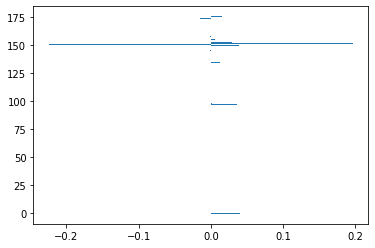

In [29]:
plt.barh(np.arange(len(gas.net_rates_of_progress)),gas.net_rates_of_progress)

In [30]:
gas.T

1126.8703906394048

In [31]:
data = pd.read_csv(output_filename)
data

,Distance (mm),T (C),P (atm),Ne,H4N2O2(2),NH2OH(3),HNO3(4),CH3OH(5),H2O(6),N2(7),...,CH2X(34),CHX(35),H2NX(212),SX(215),H2NOX(217),H3NOX(218),HNO3X(221),CH3OX(223),CH4OX(224),alpha
0,0.0000,607.699012,1.0,2.067240e-129,5.762657e-07,0.317872,0.186350,0.195526,0.169020,0.000237,...,4.236148e-28,4.094377e-25,0.000020,2.676007e-16,3.873182e-07,3.129719e-10,1.994327e-10,0.734787,2.294988e-11,5.605497e+12
1,0.0055,639.049299,1.0,2.059720e-129,8.461475e-10,0.321129,0.185515,0.194815,0.173048,0.000846,...,1.046770e-27,8.045601e-25,0.000078,1.942031e-18,7.612704e-07,1.479457e-09,9.154162e-10,0.911716,1.247511e-10,2.314374e+12
2,0.0110,650.329312,1.0,2.054982e-129,4.912470e-11,0.322873,0.184885,0.194367,0.174105,0.001664,...,1.507218e-27,1.071122e-24,0.000166,2.673491e-19,1.056224e-06,3.460429e-09,2.111739e-09,0.953453,3.052800e-10,1.962970e+12
3,0.0165,657.474863,1.0,2.050780e-129,1.585121e-11,0.323143,0.184269,0.193970,0.175195,0.002619,...,2.820465e-27,1.909291e-24,0.000201,1.147898e-19,9.218168e-07,4.553756e-09,2.758809e-09,0.957482,4.139808e-10,1.146842e+12
4,0.0220,663.199735,1.0,2.046557e-129,7.662979e-12,0.322702,0.183622,0.193570,0.176413,0.003682,...,5.155578e-27,3.358633e-24,0.000214,6.406569e-20,7.371350e-07,5.200536e-09,3.136180e-09,0.956742,4.849138e-10,7.252605e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,10.9780,853.603506,1.0,4.011917e-31,1.252223e-14,0.099850,0.000001,0.153824,0.355591,0.038481,...,3.996393e-20,9.530335e-18,0.000003,2.091013e-20,1.089133e-05,2.435456e-07,2.701113e-12,0.954084,1.207943e-07,-2.914069e+08
1997,10.9835,853.642477,1.0,4.011908e-31,1.252683e-14,0.099847,0.000001,0.153823,0.355600,0.038482,...,4.004848e-20,9.548942e-18,0.000003,2.092569e-20,1.089146e-05,2.436180e-07,2.701298e-12,0.954068,1.208487e-07,-2.909316e+08
1998,10.9890,853.681439,1.0,4.011898e-31,1.253144e-14,0.099844,0.000001,0.153823,0.355608,0.038483,...,4.013318e-20,9.567578e-18,0.000003,2.094126e-20,1.089159e-05,2.436905e-07,2.701484e-12,0.954052,1.209030e-07,-2.904574e+08
1999,10.9945,853.720391,1.0,4.011889e-31,1.253605e-14,0.099841,0.000001,0.153823,0.355616,0.038484,...,4.021803e-20,9.586245e-18,0.000003,2.095683e-20,1.089172e-05,2.437629e-07,2.701669e-12,0.954035,1.209574e-07,-2.899841e+08


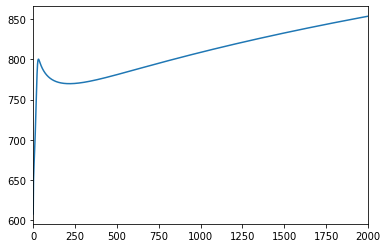

In [32]:
data['T (C)'].plot()

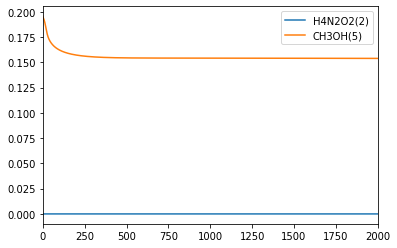

In [33]:
data[['H4N2O2(2)', 'CH3OH(5)']].plot()

In [34]:
list(data.columns)[:4]

['Distance (mm)', 'T (C)', 'P (atm)', 'Ne']

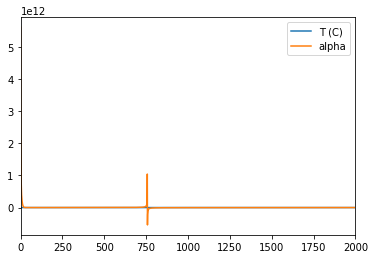

In [35]:
data[['T (C)', 'alpha']].plot()

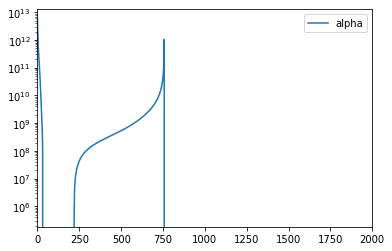

In [36]:
data[['alpha']].plot(logy=True)

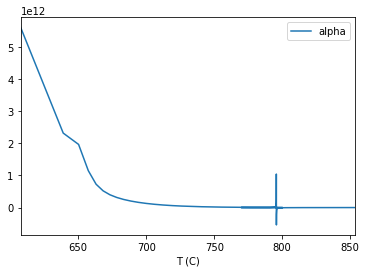

In [37]:
data.plot(x='T (C)',y='alpha')

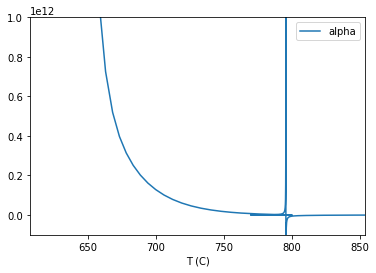

In [38]:
data.plot(x='T (C)',y='alpha', ylim=(-1e11,1e12))

In [39]:
specs = list(data.columns)
specs = specs[4:-1]

gas_species = [s for s in specs if 'X' not in s]
adsorbates = [s for s in specs if 'X' in s]

gas_species, adsorbates

(['H4N2O2(2)',
  'NH2OH(3)',
  'HNO3(4)',
  'CH3OH(5)',
  'H2O(6)',
  'N2(7)',
  'O2(8)',
  'NO2(9)',
  'NO(10)',
  'N2O(11)',
  'CO2(12)',
  'H2(13)',
  'CO(14)',
  'CH4(15)',
  'C2H6(16)',
  'CH2O(17)',
  'CH3(18)',
  'C3H8(19)',
  'H(20)',
  'C2H5(21)',
  'HCO(22)',
  'CH3CHO(23)',
  'OH(24)',
  'C2H4(25)',
  'HO2(39)',
  'NH2(85)',
  'H2NO(89)',
  'HNOH(94)',
  'N2H3(99)',
  'H3N2O(193)',
  'H2NO2(195)',
  'S(196)',
  'H2NO3(252)',
  'H2N2O(502)',
  'NNDO(506)',
  'NNO(515)',
  'S(566)'],
 ['X(1)',
  'HX(26)',
  'OX(27)',
  'CH3X(28)',
  'HOX(29)',
  'H2OX(30)',
  'CO2X(31)',
  'OCX(32)',
  'CX(33)',
  'CH2X(34)',
  'CHX(35)',
  'H2NX(212)',
  'SX(215)',
  'H2NOX(217)',
  'H3NOX(218)',
  'HNO3X(221)',
  'CH3OX(223)',
  'CH4OX(224)'])

/Users/rwest/opt/anaconda3/envs/rmg3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(left, right)


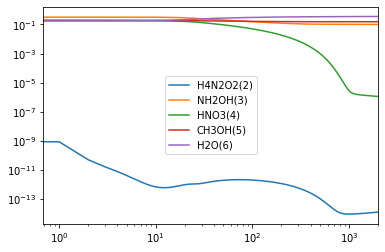

In [40]:
data[gas_species[0:5]].plot(logy=True, logx=True)

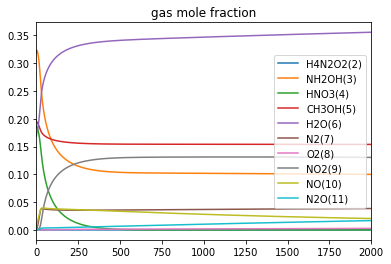

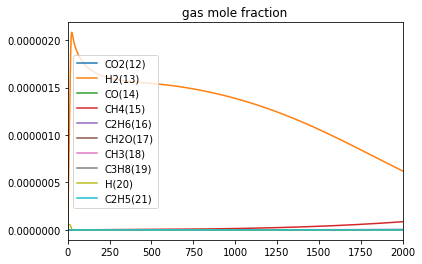

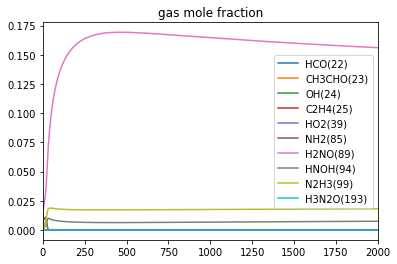

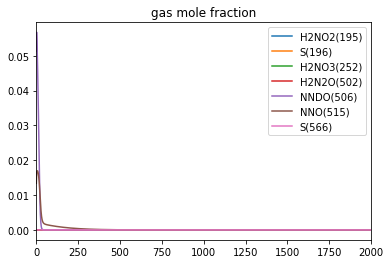

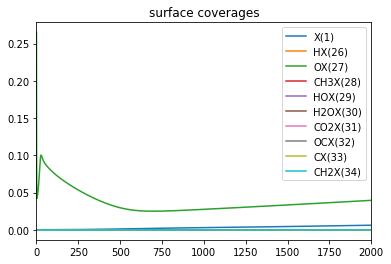

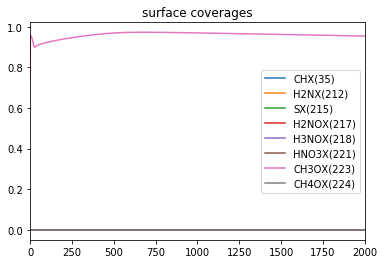

In [41]:
for i in range(0,len(gas_species),10):
    data[gas_species[i:i+10]].plot(title='gas mole fraction', logy=False)
    
for i in range(0,len(adsorbates),10):
    data[adsorbates[i:i+10]].plot(title='surface coverages', logy=False)

In [43]:
gas.species('NO2(9)').composition

{'N': 1.0, 'O': 2.0}

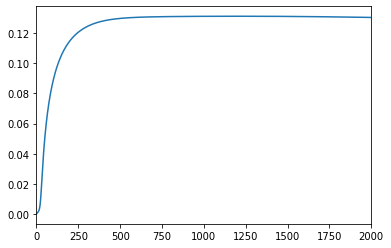

In [44]:
data['NO2(9)'].plot()

In [ ]:
(data[specs].max()>0.01)

In [ ]:
data.loc[0]